## Introduction to `robotoc` 
# 4: Optimal Control of a Quadruped

## 本章の目的
ここでは，４脚ロボットの最適制御問題（OCP）を定式化し，解くことが目的です．

まず，ANYmal の `robotoc.Robot` モデルを作成します．

In [1]:
import robotoc
contact_frames = ['LF_FOOT', 'LH_FOOT', 'RF_FOOT', 'RH_FOOT']
contact_types = [robotoc.ContactType.PointContact for _ in contact_frames]
baumgarte_time_step = 0.05
path_to_urdf = 'urdf/anymal_b_simple_description/urdf/anymal.urdf'
anymal = robotoc.Robot(path_to_urdf, robotoc.BaseJointType.FloatingBase, 
                       contact_frames, contact_types, baumgarte_time_step)

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<hpp::fcl::CollisionGeometry> already registered; second conversion method ignored.


## Cost Function（評価関数）
次に，評価関数 (cost function) を作成します．   
`robotoc.CostFunction` (`std::shared_ptr<robotoc::CostFunction>` in C++) は **cost components** のコレクションです.  
各 **cost component** はある特定の評価関数の項を表しており，`robotoc.CostFunctionComponentBase` (`robotoc::CostFunctionComponentBase` in C++) を継承しています.   
このようにすることで，複数の**cost components** を簡単に組み合わせて評価関数が設計できるようになっています.

基本的な **cost components** は `robotoc` のパッケージに既に多数実装されています.  
この例では， configuration つまり関節角，角速度，トルクなどについてのコスト，end-effector の位置追従のコスト，重心位置 (CoM)のコストを考えます．   
以下がその **cost component** です．

### Gaite Pattern (歩行パターン)
評価関数を作る前に，まずは歩行パターンを設定します．　　   
以下のようなシンプルなトロットを考えます． 

In [2]:
import numpy as np
step_length = np.array([0.15, 0, 0])
step_height = 0.1
swing_time = 0.5
double_support_time = 0.04
swing_start_time = 0.04

### Configuration Space Cost

レファレンスと重みパラメータを設定していきます．   
以下のような命名規則があります．   
- `q`: configuration (関節角)
- `v`: 一般化速度 (関節角速度)
- `a`: 一般化加速度 (関節角加速度)
- `u`: 関節トルク
- `qf`, `vf`: ホライゾン終端での関節角度と角速度
- `qi`, `vi`: インパクトの瞬間（この例では振り足と地面との衝突）での関節角度と角速度
- `dvi`: インパクトによる一般加速度の不連続変化

In [3]:
q_standing = np.array([0, 0, 0.4792, 0, 0, 0, 1, 
                       -0.1,  0.7, -1.0, 
                       -0.1, -0.7,  1.0, 
                        0.1,  0.7, -1.0, 
                        0.1, -0.7,  1.0])
q_weight = np.array([0, 0, 0, 250000, 250000, 250000, 
                     0.0001, 0.0001, 0.0001, 
                     0.0001, 0.0001, 0.0001,
                     0.0001, 0.0001, 0.0001,
                     0.0001, 0.0001, 0.0001])
v_weight = np.array([100, 100, 100, 100, 100, 100, 
                     1, 1, 1, 
                     1, 1, 1,
                     1, 1, 1,
                     1, 1, 1])
u_weight = np.full(anymal.dimu(), 1.0e-01)
qi_weight = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
                      100, 100, 100, 
                      100, 100, 100,
                      100, 100, 100,
                      100, 100, 100])
vi_weight = np.full(anymal.dimv(), 100)
config_cost = robotoc.ConfigurationSpaceCost(anymal)
config_cost.set_q_ref(q_standing)
config_cost.set_q_weight(q_weight)
config_cost.set_qf_weight(q_weight)
config_cost.set_qi_weight(qi_weight)
config_cost.set_v_weight(v_weight)
config_cost.set_vf_weight(v_weight)
config_cost.set_vi_weight(vi_weight)
config_cost.set_u_weight(u_weight)

### Task Space Cost
次に脚先の位置追従を表す，タスク空間のコストを，各脚に合計4つ定義していきます．
このようなコストは， `robotoc.TimeVaryingTaskSpace3DCost` (`std::shared_ptr<robotoc::TimeVaryingTaskSpace3DCost>` in C++) を用いて定義できます.  
各 `robotoc.TimeVaryingTaskSpace3DCost`では, `robotoc.TimeVaryingTaskSpace3DRefBase` (`robotoc::TimeVaryingTaskSpace3DRefBase` in C++) を継承したレファレンスクラスを指定する必要があります．   
シンプルな歩行に対して， `robotoc.PeriodicFootTrackRef` (`robotoc::PeriodicFootTrackRef` in C++) が既に実装されています．   
これには， initial position (初期位置), step length (ステップの距離), step height (振り足の目標高さ), swing-start time (その脚が振り始める時間), swing time (スイングしている時間), support time (地面に立っている時間), and whether the initial step-length is half or not, を指定します.

まず各脚の初期位置を得るために，直立している姿勢（デフォルトの姿勢）での各脚の位置を forward kinematics から得ます．

In [4]:
anymal.forward_kinematics(q_standing)
x3d0_LF = anymal.frame_position('LF_FOOT')
x3d0_LH = anymal.frame_position('LH_FOOT')
x3d0_RF = anymal.frame_position('RF_FOOT')
x3d0_RH = anymal.frame_position('RH_FOOT')

これと歩行パターンに基づいて時変の脚先位置のレファレンスをそれぞれの脚について作ります．

In [5]:
LF_t0 = swing_start_time + swing_time + double_support_time
LH_t0 = swing_start_time
RF_t0 = swing_start_time
RH_t0 = swing_start_time + swing_time + double_support_time
LF_foot_ref = robotoc.PeriodicFootTrackRef(x3d0_LF, step_length, step_height, 
                                           LF_t0, swing_time, 
                                           swing_time+2*double_support_time, False)
LH_foot_ref = robotoc.PeriodicFootTrackRef(x3d0_LH, step_length, step_height, 
                                           LH_t0, swing_time, 
                                           swing_time+2*double_support_time, True)
RF_foot_ref = robotoc.PeriodicFootTrackRef(x3d0_RF, step_length, step_height, 
                                           RF_t0, swing_time, 
                                           swing_time+2*double_support_time, True)
RH_foot_ref = robotoc.PeriodicFootTrackRef(x3d0_RH, step_length, step_height, 
                                           RH_t0, swing_time, 
                                           swing_time+2*double_support_time, False)

このレファレンスを用いて脚先位置追従のコストを作ります．

In [6]:
LF_cost = robotoc.TimeVaryingTaskSpace3DCost(anymal, 'LF_FOOT', LF_foot_ref)
LH_cost = robotoc.TimeVaryingTaskSpace3DCost(anymal, 'LH_FOOT', LH_foot_ref)
RF_cost = robotoc.TimeVaryingTaskSpace3DCost(anymal, 'RF_FOOT', RF_foot_ref)
RH_cost = robotoc.TimeVaryingTaskSpace3DCost(anymal, 'RH_FOOT', RH_foot_ref)
foot_track_weight = np.full(3, 1.0e06)
LF_cost.set_x3d_weight(foot_track_weight)
LH_cost.set_x3d_weight(foot_track_weight)
RF_cost.set_x3d_weight(foot_track_weight)
RH_cost.set_x3d_weight(foot_track_weight)

### Center of Mass (CoM) Cost

脚先と同様に，重心位置 (CoM) のコストを作ります．   
まずは，CoMの位置についての時変のレファレンスを作ります．

In [7]:
com_ref0 = anymal.com()
vcom_ref = 0.5 * step_length / swing_time
com_ref = robotoc.PeriodicCoMRef(com_ref0, vcom_ref, swing_start_time, swing_time, 
                                 double_support_time, True)

このレファレンスから，CoM位置のコストを作ります．

In [8]:
com_cost = robotoc.TimeVaryingCoMCost(anymal, com_ref)
com_cost.set_com_weight(np.full(3, 1.0e06))

以上のコストを`CostFunction`にまとめます．

In [9]:
cost = robotoc.CostFunction()
cost.push_back(config_cost)
cost.push_back(LF_cost)
cost.push_back(LH_cost)
cost.push_back(RF_cost)
cost.push_back(RH_cost)
cost.push_back(com_cost)

## Constraints（制約）
制約についても評価関数と同様に作成します．   
`robotoc.Constraints` (`std::shared_ptr<robotoc::Constraints>` in C++) は **constraint components**のコレクションになっています.
各 **constraints component** はある特定の制約を表しており， `robotoc.ConstraintComponentBase` (`robotoc::ConstraintComponentBase` in C++) を継承しています．     
これにより，様々な **constraints components** を簡単に組み合わせて制約を設計できます.

基本的な **constraint components** のは既に `robotoc` に多数実装されています.  
この例では，関節角度，角速度，トルクの制約を考えます．     

In [10]:
joint_position_lower  = robotoc.JointPositionLowerLimit(anymal)
joint_position_upper  = robotoc.JointPositionUpperLimit(anymal)
joint_velocity_lower  = robotoc.JointVelocityLowerLimit(anymal)
joint_velocity_upper  = robotoc.JointVelocityUpperLimit(anymal)
joint_torques_lower   = robotoc.JointTorquesLowerLimit(anymal)
joint_torques_upper   = robotoc.JointTorquesUpperLimit(anymal)

さらに，摩擦錐 (friction cone) 制約をつくります．    
`mu`は摩擦係数です.

In [11]:
mu = 0.7
friction_cone = robotoc.FrictionCone(anymal, mu)

制約を作り，上記のコンポーネントを加えます．

In [12]:
constraints = robotoc.Constraints()
constraints.push_back(joint_position_lower)
constraints.push_back(joint_position_upper)
constraints.push_back(joint_velocity_lower)
constraints.push_back(joint_velocity_upper)
constraints.push_back(joint_torques_lower)
constraints.push_back(joint_torques_upper)
constraints.push_back(friction_cone)

## Contact Sequence（接触系列）
Contact sequence は接触状況 (どの接触がアクティブなのか？) や接触の位置の系列を記述したものです.  
これをOCPソルバーに渡すことで，OCPソルバーは自動的に問題を contact sequence に合わせて定式化してくれます．

この例では，次の回数だけのトロットを考えます．

In [13]:
cycle = 3

Contact sequence を作る際には，起こりうる最大の不連続イベント （接触状況の切り替え） を指定します．   
ここでは，以下のように contact sequence を作ります．

In [14]:
max_num_each_discrete_events = 2*cycle
contact_sequence = robotoc.ContactSequence(anymal, max_num_each_discrete_events)

逐次的に contact sequence を作り上げていきます．   
まずは，初期状態での `robotoc.ContactStatus`をつくります．   
この`robotoc.ContactStatus`に接触状況（接触がアクティブか否か，接触の位置）を記述します．   
初期状態では全ての脚での接触はアクティブです．      
従って，以下のように記述します．

In [15]:
contact_positions = {'LF_FOOT': x3d0_LF, 'LH_FOOT': x3d0_LH, 'RF_FOOT': x3d0_RF, 'RH_FOOT': x3d0_RH} 
contact_status_standing = anymal.create_contact_status()
contact_status_standing.activate_contacts(['LF_FOOT', 'LH_FOOT', 'RF_FOOT', 'RH_FOOT'])
contact_status_standing.set_contact_placements(contact_positions)

これを用いて contact sequence を初期化します．

In [16]:
contact_sequence.init_contact_sequence(contact_status_standing)

次に， LF_FOOT と RH_FOOT の接触がアクティブ（地面についている）で， LH_FOOT　と RF_FOOT が振り脚になっている状況を考えます． 

In [17]:
contact_status_lhrf_swing = anymal.create_contact_status()
contact_status_lhrf_swing.activate_contacts(['LF_FOOT', 'RH_FOOT'])
contact_status_lhrf_swing.set_contact_placements(contact_positions)

こちらを contact sequence に加えます．(push_backします．)

In [18]:
contact_sequence.push_back(contact_status_lhrf_swing, swing_start_time)

次に，再び４つの脚が地面につきます．   
振り脚であった LH_FOOT と　RF_FOOT は 0.5 x step_length だけ進んでいます.   
こちらは以下のように書くことができます．

In [19]:
contact_positions['LH_FOOT'] += 0.5 * step_length
contact_positions['RF_FOOT'] += 0.5 * step_length
contact_status_standing.set_contact_placements(contact_positions)
contact_sequence.push_back(contact_status_standing, swing_start_time+swing_time)

次は， LF_FOOT と RH_FOOT が地面についていて（接触がアクティブ）， LF_FOOT と RH_FOOT が振り脚（接触がアクティブでない）状況を考えます．   

In [20]:
contact_status_lfrh_swing = anymal.create_contact_status()
contact_status_lfrh_swing.activate_contacts(['LH_FOOT', 'RF_FOOT'])
contact_status_lfrh_swing.set_contact_placements(contact_positions)
contact_sequence.push_back(contact_status_lfrh_swing, 
                           swing_start_time+swing_time+double_support_time)

その次は，再び4脚が地面につきます．  
振り脚だった脚は step_length だけ進んでいます．

In [21]:
contact_positions['LF_FOOT'] += step_length
contact_positions['RH_FOOT'] += step_length
contact_status_standing.set_contact_placements(contact_positions)
contact_sequence.push_back(contact_status_standing, 
                           swing_start_time+2*swing_time+double_support_time)

これを指定した cycle の数だけ繰返します．

In [22]:
for i in range(cycle-1):
    t1 = swing_start_time + (i+1)*(2*swing_time+2*double_support_time)
    contact_status_lhrf_swing.set_contact_placements(contact_positions)
    contact_sequence.push_back(contact_status_lhrf_swing, t1)

    contact_positions['LH_FOOT'] += step_length
    contact_positions['RF_FOOT'] += step_length
    contact_status_standing.set_contact_placements(contact_positions)
    contact_sequence.push_back(contact_status_standing, t1+swing_time)

    contact_status_lfrh_swing.set_contact_placements(contact_positions)
    contact_sequence.push_back(contact_status_lfrh_swing, 
                               t1+swing_time+double_support_time)

    contact_positions['LF_FOOT'] += step_length
    contact_positions['RH_FOOT'] += step_length
    contact_status_standing.set_contact_placements(contact_positions)
    contact_sequence.push_back(contact_status_standing, 
                               t1+2*swing_time+double_support_time)

## Optimal Control Problem (OCP) and Solver

ここでは最適制御問題 (OCP) とそのソルバーを作ります．  
まずはホライゾン長さ `T` と離散化のグリッドの数 `N` を設定しましょう． 

In [23]:
T = swing_start_time + cycle*(2*double_support_time+2*swing_time)
dt = 0.02
N = int(np.floor(T/dt))    

今回考えているロボットは接触や floating base を伴うため，`robotoc.OCP` (`robotoc::OCP` in C++) を用いて問題を記述します.      
このとき，再び起こりうる最大の不連続現象（接触状況の切り替え）を指定します.

In [24]:
ocp = robotoc.OCP(robot=anymal, cost=cost, constraints=constraints, 
                  T=T, N=N, max_num_each_discrete_events=max_num_each_discrete_events)

ではこのOCPのソルバー`robotoc.OCPSolver` (`robotoc::OCPSolver` in C++)　を作ります．   
このソルバーは以下の特徴があります: 
- Direct multiple-shooting 法　と primal-dual interior point 法 （主双対内点法）
- Inverse dynamics を用いた **unconstrained** OCP　 (i.e., no contacts or floating bases) の効率的なアルゴリズム.
- 状態のみの等式制約のための制約変換法
- Riccati recursion によるニュートンステップの計算
- スイッチ時刻最適化可能な Riccati recursion アルゴリズム（この例では用いていません）

種々のソルバーのオプションを `robotoc.SolverOptions` により設定できます．(ここではデフォルトのパラメータを用います).  
また，ソルバー作成時に並列計算で用いるスレッドの数を指定します.

In [25]:
solver_options = robotoc.SolverOptions()
ocp_solver = robotoc.OCPSolver(ocp=ocp, contact_sequence=contact_sequence, 
                               solver_options=solver_options, nthreads=4)

## Solve the OCP

初期状態 (`q`, `v`) と初期時刻が以下で与えられるOCP（最適制御問題）を考えます．

In [26]:
t = 0.
q = q_standing.copy()
v = np.zeros(anymal.dimv())

まずはソルバーを初期化します．   
以下は初期推定解を上の`q`, `v`に設定します．    
さらに，接触力の推定解をロボットの weight から設定します．   
これは非常にシンプルですが高速な収束に割と重要です．

In [27]:
ocp_solver.set_solution("q", q)
ocp_solver.set_solution("v", v)
f_init = np.array([0.0, 0.0, 0.25*anymal.total_weight()])
ocp_solver.set_solution("f", f_init)

また，不等式制約に関してソルバーを初期化します．    
(具体的には，主双対内点法のスラック変数とラグランジュ乗数を初期化しますが，特に内部について意識する必要はありません).

In [28]:
ocp_solver.init_constraints(t)

ソルバーの現在の推定解がどの程度最適解に近いか，ということを判断するために，本ソルバーでは **KKT error** という指標を用います．   
これは， Karush–Kuhn–Tucker (KKT) 条件（1次の最適性の必要条件）のl2ノルムです．　（最適解でこれは0になります）   
まず，初期化後の KKT error を見てみます． 

In [29]:
ocp_solver.KKT_error(t, q, v)

183854.86398696332

次にOCPを解きます．

In [30]:
ocp_solver.solve(t, q, v)

KKT error がとても小さくなっていることが分かります．    
(具体的には，`robotoc.SolverOption`で設定した閾値より小さくなっています).

In [31]:
ocp_solver.KKT_error(t, q, v)

2.4514280927662963e-09

また，各反復での KKT error やステップサイズといった情報も以下で見れます．

In [32]:
stats = ocp_solver.get_solver_statistics()
print(stats)

Solver statistics:
  convergence: true
  total no. of iteration: 12
  ------------------------------------------------------------------------------------ 
   iteration |      KKT error | primal step size |   dual step size |        ts        
  ------------------------------------------------------------------------------------ 
           1 |   1.838549e+05 |     8.417356e-01 |     2.541203e-01 |
           2 |   2.848656e+04 |     3.498618e-01 |     1.000000e+00 |
           3 |   1.851484e+04 |     4.015650e-01 |     1.000000e+00 |
           4 |   1.107759e+04 |     1.000000e+00 |     1.000000e+00 |
           5 |   7.229661e+00 |     1.000000e+00 |     1.000000e+00 |
           6 |   9.512227e-02 |     1.000000e+00 |     1.000000e+00 |
           7 |   4.696054e-03 |     1.000000e+00 |     1.000000e+00 |
           8 |   1.991877e-04 |     1.000000e+00 |     1.000000e+00 |
           9 |   1.604784e-05 |     1.000000e+00 |     1.000000e+00 |
          10 |   1.714934e-06 |     1.

最適軌道のconfiguration, 一般化速度，関節トルクをプロットしてみます．   

Text(0, 0.5, 'u [Nm]')

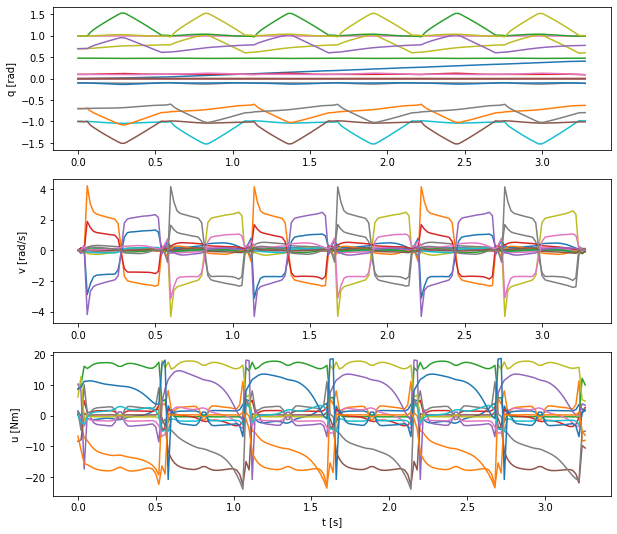

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

plt.rcParams['figure.figsize'] = 10, 9
fig = plt.figure()
ax_q = fig.add_subplot(3, 1, 1)
ax_v = fig.add_subplot(3, 1, 2)
ax_u = fig.add_subplot(3, 1, 3)

# Plot results
ax_q.plot(np.linspace(t, t+T, N+1), ocp_solver.get_solution('q'))
ax_v.plot(np.linspace(t, t+T, N+1), ocp_solver.get_solution('v'))
ax_u.plot(np.linspace(t, t+T-(T/N), N), ocp_solver.get_solution('u'))

ax_q.set_xlabel('')
ax_v.set_xlabel('')
ax_u.set_xlabel('t [s]')

ax_q.set_ylabel('q [rad]')
ax_v.set_ylabel('v [rad/s]')
ax_u.set_ylabel('u [Nm]')

`robotoc` は接触力を friction cone 制約とともにプロットするモジュールも提供しています．   
グレーのハッチが fx と fy の infeasible な領域を表しています.

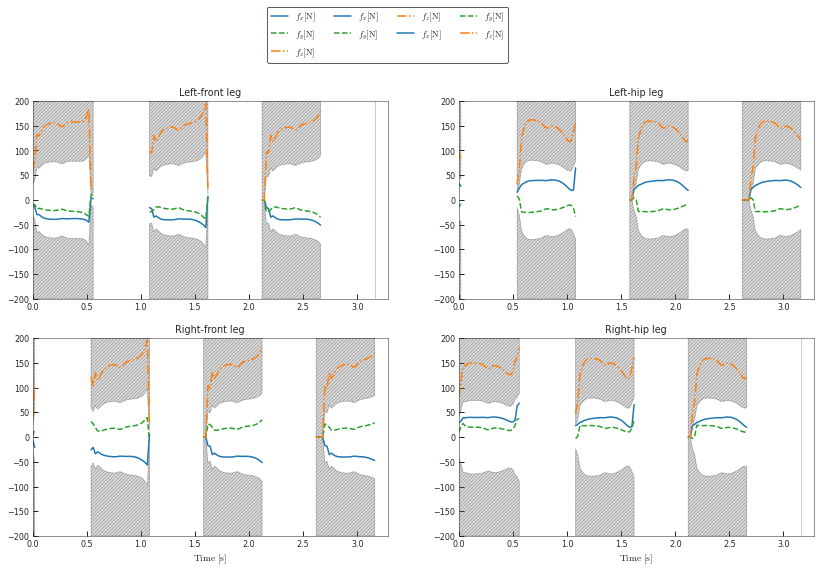

In [34]:
plot_f = robotoc.utils.PlotContactForce(mu=mu)
plot_f.figsize = 14, 8
plot_f.wspace = 0.2
plot_f.hspace = 0.2
plot_f.legend_bbox_to_anchor = (-0.2, 2.7)
plot_f.plot(f_data=ocp_solver.get_solution('f', 'WORLD'), 
            t=ocp_solver.get_time_discretization().time_points())

また収束をプロットするモジュールもあります．

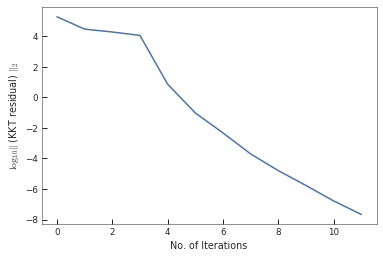

In [35]:
plot_kkt = robotoc.utils.PlotConvergence()
#plot_kkt.ylim = [0., 1.5]
plot_kkt.figsize = 6, 4
plot_kkt.plot(kkt_data=ocp_solver.get_solver_statistics().kkt_error)

また，以下で最適化された軌道を可視化できます．   
'gepetto' を viewer に選べば， 接触力および friction cone も可視化できます．

In [36]:
viewer = robotoc.utils.TrajectoryViewer(path_to_urdf=path_to_urdf, 
                                        base_joint_type=robotoc.BaseJointType.FloatingBase,
                                        viewer_type='gepetto')
viewer.set_contact_info(anymal.contact_frames(), mu)
discretization = ocp_solver.get_time_discretization()
viewer.display(discretization.time_steps(), ocp_solver.get_solution('q'), 
               ocp_solver.get_solution('f', 'WORLD'))